# SARIMAX model 

In [1]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

Source: Statistics Canada. Table 32-10-0077-01  [Farm product prices, crops and livestock](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3210007701)

In [3]:
# Load data
df = pd.read_csv('data/farm_product_price_saskatchewan.csv')
print(df.shape)
df.head()

(454, 3)


,Date,Barley,Cattle
0,Jan-85,121.38,70.61
1,Feb-85,119.64,70.28
2,Mar-85,122.70,69.31
3,Apr-85,125.48,70.67
4,May-85,118.85,70.77


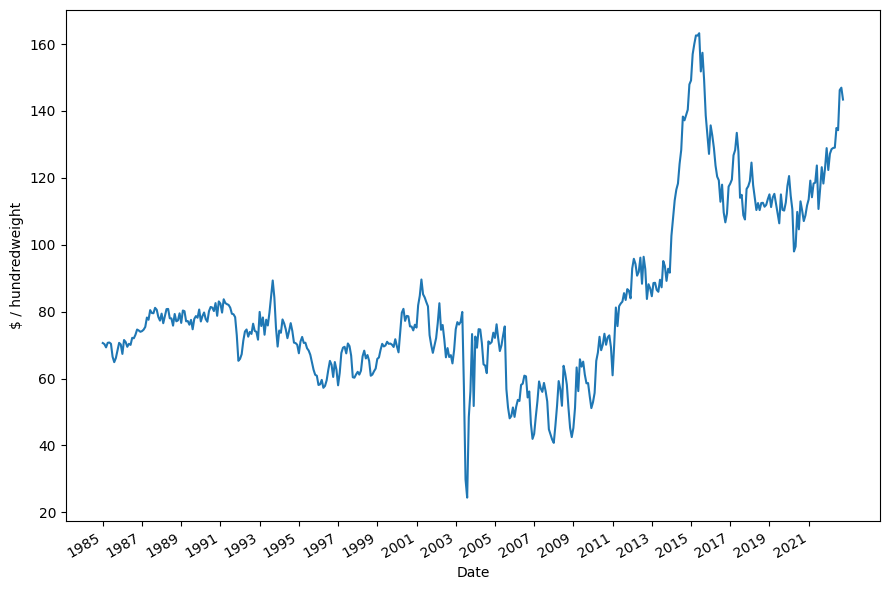

In [4]:
fig, ax = plt.subplots()

ax.plot(df['Cattle'])
ax.set_xlabel('Date')
ax.set_ylabel('$ / hundredweight')

plt.xticks(np.arange(0, 453, 24), np.arange(1985, 2023, 2))

fig.autofmt_xdate()
plt.tight_layout()

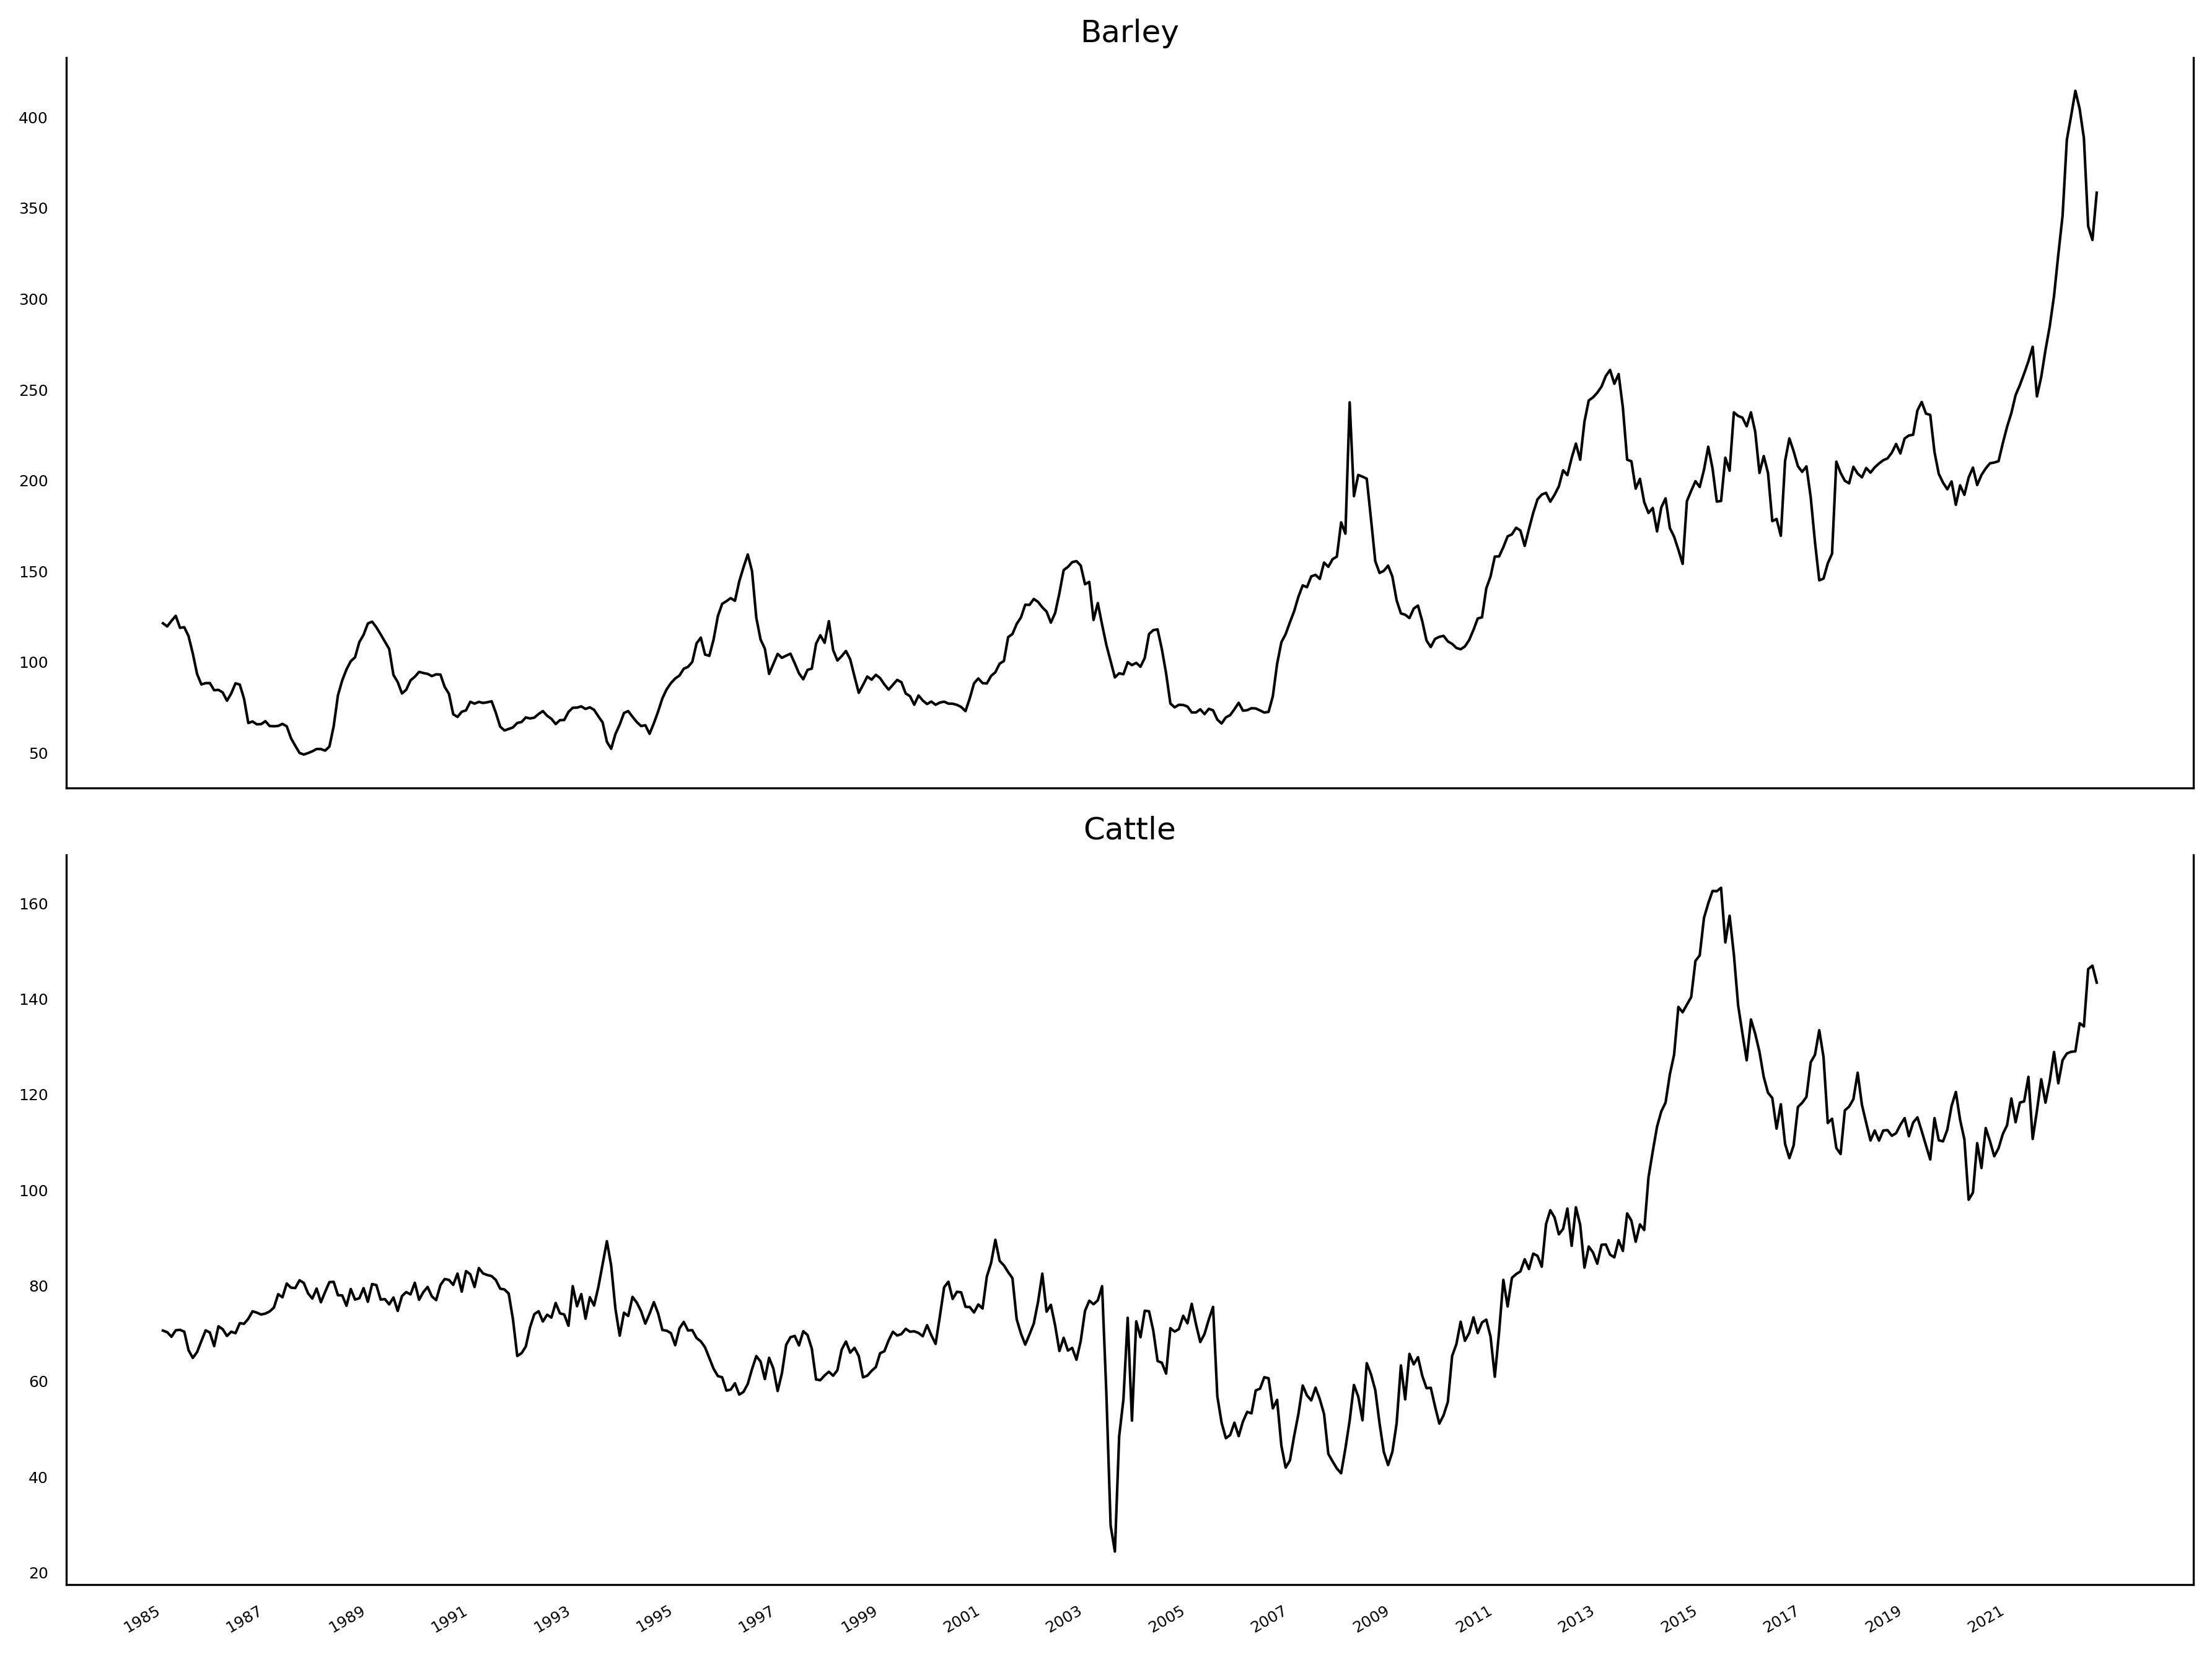

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=300, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i+1]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+1])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 453, 24), xticklabels=np.arange(1985, 2022, 2))

fig.autofmt_xdate()

plt.tight_layout()

## Forecasting with SARIMAX 

In [6]:
# define out target and exogenous variable
target = df['Cattle']
exog = df['Barley']

### Check for stationarity 

In [8]:
ad_fuller_result = adfuller(target)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8220717001471055
p-value: 0.8125525478214064


In [9]:
# Difference the series
target_diff = target.diff()
# Run the ADF test
ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.710458961743209
p-value: 7.320051651999116e-07


### Train/test split 

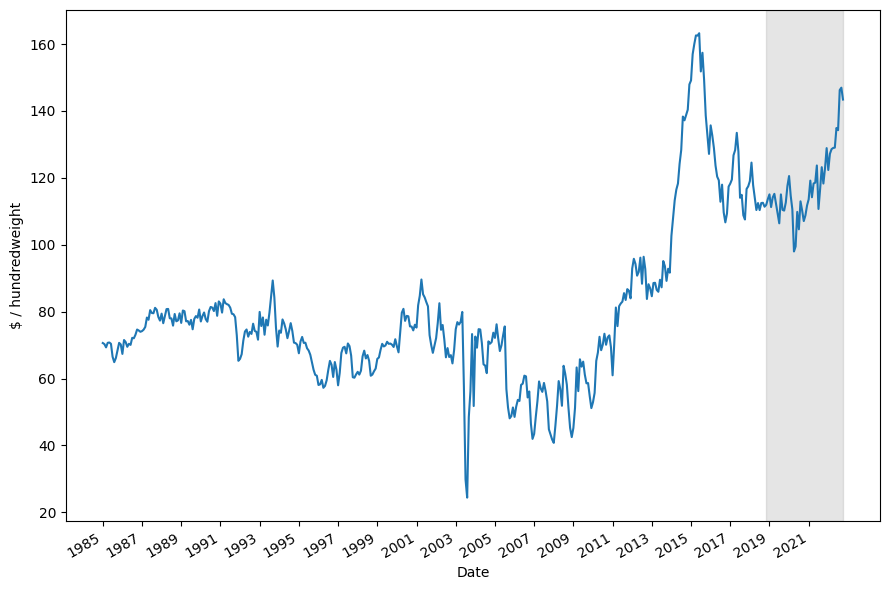

In [10]:
fig, ax = plt.subplots()

ax.plot(df['Cattle'])
ax.set_xlabel('Date')
ax.set_ylabel('$ / hundredweight')
ax.axvspan(406, 453, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 453, 24), np.arange(1985, 2023, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
# Keep the last 48 time steps for the test set
target_train = target[:-48]
target_test = target[-48:]

exog_train = exog[:-48]


### Model selection with AIC 

In [12]:
def SARIMAX_gridsearch(endog, exog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)
    
    all_orders = list(product(all_p, all_q, all_P, all_Q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            # Fit a SARIMAX model
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
            
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [13]:
# Run gridssearch
result_df = SARIMAX_gridsearch(target_train, exog_train, 0,4,0,4,0,2,0,2, 1, 0, 12)
result_df.head()

Fitting 225 unique models


  0%|          | 0/225 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(4, 4, 2, 0)",2400.704807
1,"(4, 4, 0, 2)",2400.797602
2,"(4, 4, 2, 1)",2402.860665
3,"(4, 4, 1, 2)",2403.026795
4,"(4, 4, 2, 2)",2404.494475


In [14]:
# Now with optimal parameters
SARIMAX_model = SARIMAX(target_train, exog_train, order=(4,1,4), seasonal_order=(2, 0, 0, 12), simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)

### Residuals analysis 

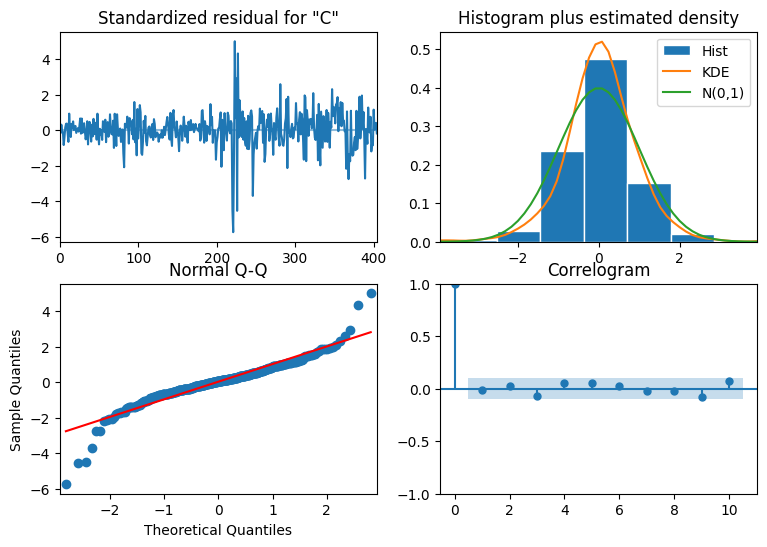

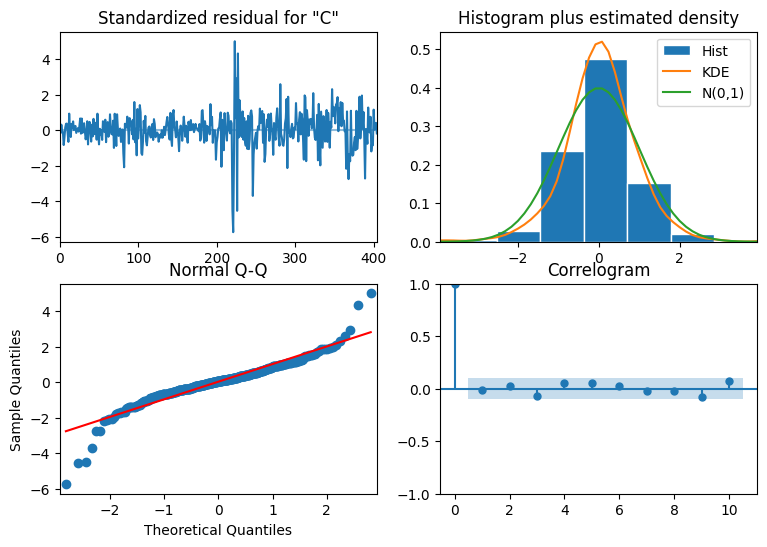

In [15]:
SARIMAX_model_fit.plot_diagnostics()

In [17]:
# Define residuals
residuals = SARIMAX_model_fit.resid

In [16]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


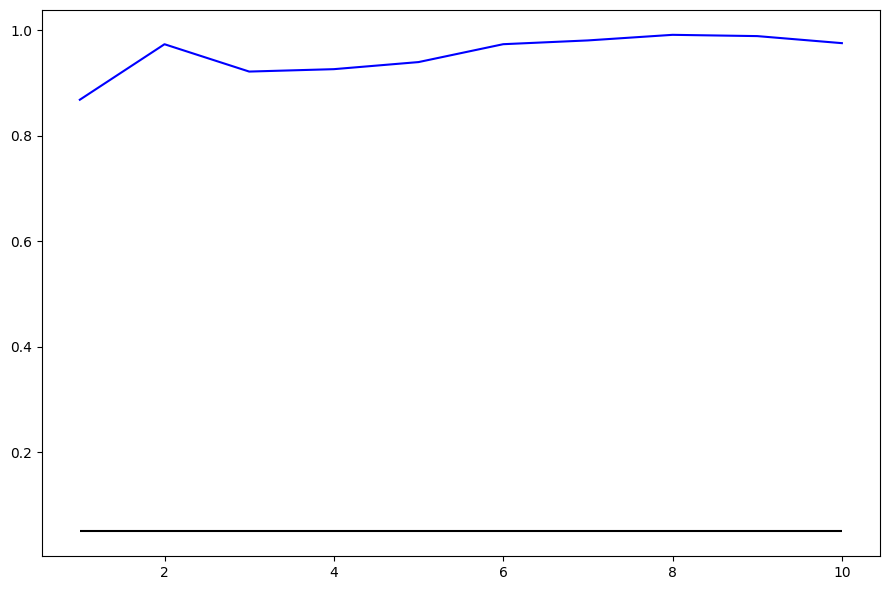

In [18]:
ljung_box_test(residuals, False,None)

### Forecasting 

In [21]:
def rolling_predictions(endog, exog, train_len, horizon, window, method):
    
    TOTAL_LEN = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(endog[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value[:horizon]
    
    if method == 'SARIMAX':
        # Get the predictions from the SARIMAX model
        pred_SARIMAX = []

        # Iterate through
        for i in range(train_len, TOTAL_LEN, window):

            model = SARIMAX(endog[:i], exog[:i], order=(4,1,4), seasonal_order=(2,0,0,12))
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog[:i])
            oos_pred = predictions.predicted_mean[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX[:horizon]

In [22]:
pred_df = df[-48:]
pred_df = pred_df.drop(['Barley'], axis=1)

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_mean = rolling_predictions(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_predictions(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_predictions(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last'] = pred_last
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df.head()

,Date,Cattle,pred_mean,pred_last,pred_SARIMAX
406,18-Nov,111.90,78.630468,111.36,112.212436
407,18-Dec,113.64,78.712211,111.90,114.391249
408,19-Jan,115.05,78.797819,113.64,111.886409
409,19-Feb,111.26,78.886455,115.05,113.714524
410,19-Mar,114.14,78.965415,111.26,117.267937


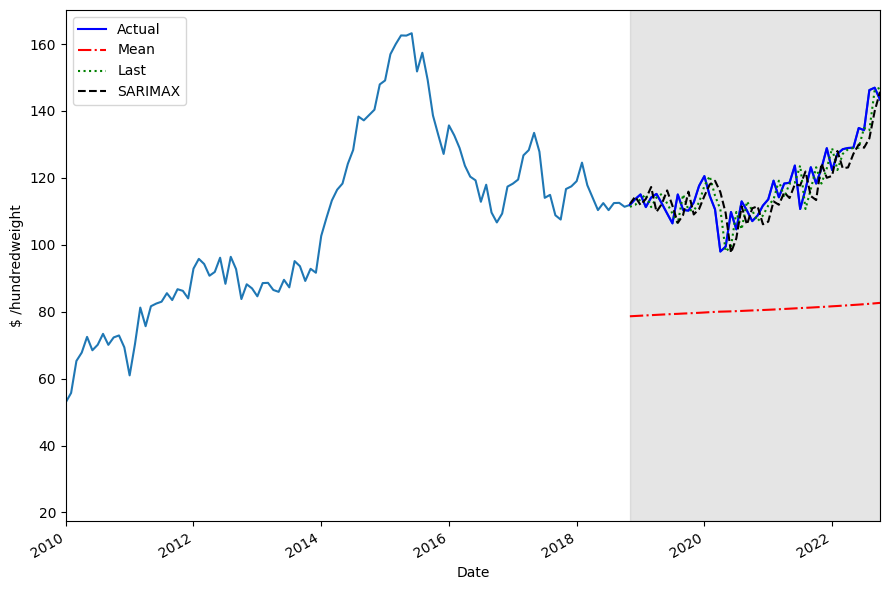

In [23]:
fig, ax = plt.subplots()

ax.plot(df['Cattle'])
ax.plot(pred_df['Cattle'], 'b-', label='Actual')
ax.plot(pred_df['pred_mean'], 'r-.', label='Mean')
ax.plot(pred_df['pred_last'], 'g:', label='Last')
ax.plot(pred_df['pred_SARIMAX'], 'k--', label='SARIMAX')
ax.legend(loc=2)
ax.set_xlabel('Date')
ax.set_ylabel('$ /hundredweight')
ax.axvspan(406, 453, color='#808080', alpha=0.2)
ax.set_xlim(300, 453)

plt.xticks(np.arange(300, 453, 24), np.arange(2010, 2023, 2))

fig.autofmt_xdate()
plt.tight_layout()

### Evaluation

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_mean = mape(pred_df['Cattle'], pred_df['pred_mean'])
mape_last = mape(pred_df['Cattle'], pred_df['pred_last'])
mape_SARIMAX = mape(pred_df['Cattle'], pred_df['pred_SARIMAX'])

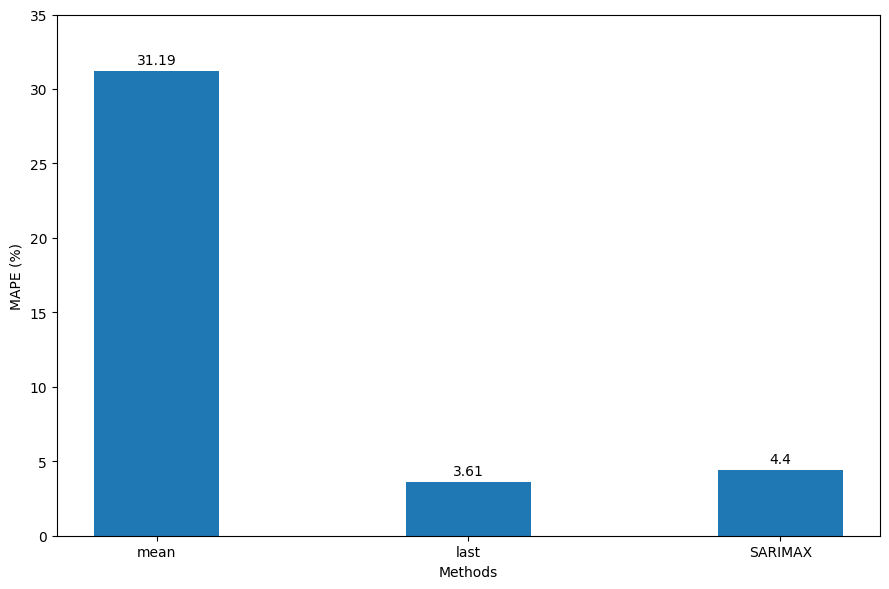

In [26]:
fig, ax = plt.subplots()

x = ['mean', 'last', 'SARIMAX']
y = [mape_mean, mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 35)

for index, value in enumerate(y):
    ax.text(x=index, y=value+0.5, s=str(round(value, 2)), ha='center')
    
plt.tight_layout()